In [1]:
%matplotlib inline

# Double DDQN을 활용한 CartPole 환경 학습

[OpenAI Gym](https://gym.openai.com/)의 CartPole-v1 태스크에서 Double DQN (Deep Q Learning) 에이전트를 학습한다.  
사용된 코드의 출처는 [PyTorch - 강화 학습 (DQN) 튜토리얼](https://tutorials.pytorch.kr/intermediate/reinforcement_q_learning.html)이며 여기서 사용된 DQN 모델을 Double DDQN 모델로 수정하였다.

In [2]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


env = gym.make('CartPole-v1').unwrapped

# matplotlib 설정
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# GPU를 사용할 경우
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


c:\Users\slem1\anaconda3\envs\ml-agents-release19\lib\site-packages\gym\utils\passive_env_checker.py:98: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  "We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) "


## Replay Buffer

DQN 학습을 위해 Replay Buffer를 사용한다. 에이전트가 관찰한 transition들을 저장해 놓고 무작위 샘플링을 통해 재사용함으로써 transition들을 decorrelated하게 만들어 학습을 안정시킨다.

이를 위해서 두개의 클래스 정의:

*  `Transition` - $S_t$에서 $S_{t+1}$로의 전환을 나타내는 tuple
*  `ReplayBuffer` - 최근 관찰된 transition들을 보관하는 제한된 크기의 순환 버퍼.
   또한 학습을 위한 transition의 무작위 샘플링 기능을 제공.

In [3]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayBuffer(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """transition 저장"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

## Training Algorithm

학습 알고리즘으로 Double DQN과 Dueling DQN을 결합한 알고리즘을 사용하였다.

### Double DQN 알고리즘

Double DQN은 2개의 신경망이 필요하다. 원래 DQN 알고리즘에서 사용되던 Deep Q Network에 Target Network가 추가되었다.  
Double DQN에서 target $Y_t^{\text{DoubleDQN}}$은 아래와 같다. 아래 현재 $S_t$에서의 추정치와 target과의 손실을 최소화하는 방향으로 학습한다.

$$
Y_t^{\text{DoubleDQN}} \doteq R_{t+1} + \gamma Q(S_{t+1}, \argmax_{a}Q(S_{t+1}, a ; \theta_t), \theta_t^-)
$$

$\theta_t$는 policy network의 매개변수, $\theta_t^-$는 target network의 매개변수이다. 즉, policy network에서 next state에서의 최적의 행동을 선택 후 이 행동의 action value $Q$를 target network에서 획득하는 구조이다. 구조 그림은 아래와 같다.

![](https://i.imgur.com/qkO3sOc.jpg)

policy network는 끊임없이 업데이트되지만 target network는 일정 주기마다 policy network의 신경망 매개변수를 복사한다. 이러한 구조는 기존 DQN 알고리즘에서 발생했던 action value의 과추정 문제를 개선해 준다고 알려져있다.

> Reference: [Deep Reinforcement Learning with Double Q-learning](https://arxiv.org/abs/1509.06461)

### Dueling DQN 알고리즘

Dueling DQN (DDQN)은 기존 DQN에 *Advantage*라는 개념을 추가해 network를 2개의 독립적인 value stream과 advantage stream으로 나누어 action value $Q$를 추정하는 방법이다. Advantage는 다른 action을 취했을 때보다 얼마나 더 좋은지를 나타내는 함수이다.

$$
Q(s, a; \theta, \alpha, \beta) = V(s; \theta, \beta) + \Big( A(s, a; \theta, \alpha) - \dfrac{1}{\mathcal{\vert A \vert}}\sum_{a'}A(s, a; \theta, \alpha) \Big)
$$

 이 방식의 장점은 agent가 각 state마다 action을 해보면서 결과를 학습하지 않아도 어떤 state가 valuable한 지 알 수 있다고 알려져있다. 따라서 기존 DQN보다 훨씬 효율적인 연산과 퀄리티 있는 학습이 가능해진다. 구조는 아래와 같다.

![](https://miro.medium.com/max/1400/1*GKZ-cS0mCdXMOO_bfBlN0Q.png)

> Reference: [Dueling Network Architectures for Deep Reinforcement Learning](https://arxiv.org/abs/1511.06581)

### DDQN class

convolution layer가 존재하는 Dueling DQN class이다.

In [4]:
class DDQN(nn.Module):

    def __init__(self, h, w, outputs):
        super(DDQN, self).__init__()
        
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        
        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=5, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=5, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        
        self.advantage = nn.Sequential(
            nn.Linear(linear_input_size, 64),
            nn.ReLU(),
            nn.Linear(64, outputs)
        )
        
        self.value = nn.Sequential(
            nn.Linear(linear_input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = x.to(device)
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1) # flatten
        advantage = self.advantage(x)
        value = self.value(x)
        
        return value + (advantage - advantage.mean())

아래 코드는 `torchvision`을 활용해 렌더링 된 이미지를 추출하고 처리하는 유틸리티이다.

c:\Users\slem1\anaconda3\envs\ml-agents-release19\lib\site-packages\torchvision\transforms\transforms.py:333: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


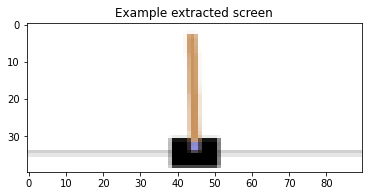

In [5]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])


def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

def get_screen():
    # gym이 요청한 화면은 400x600x3 이지만, 가끔 800x1200x3 처럼 큰 경우가 있습니다.
    # 이것을 Torch order (CHW)로 변환한다.
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    # 카트는 아래쪽에 있으므로 화면의 상단과 하단을 제거하십시오.
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # 카트를 중심으로 정사각형 이미지가 되도록 가장자리를 제거하십시오.
    screen = screen[:, :, slice_range]
    # float 으로 변환하고,  rescale 하고, torch tensor 로 변환하십시오.
    # (이것은 복사를 필요로하지 않습니다)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # 크기를 수정하고 배치 차원(BCHW)을 추가하십시오.
    return resize(screen).unsqueeze(0)


env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

## Training

학습에 필요한 하이퍼 파라미터와 유틸리티를 정의한다.  
Double DDQN을 사용하기 위해 `policy_net`과 `target_net` 변수에 `DDQN` class를 instantiate하였다.

In [6]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10
LEARNING_RATE = 0.001

init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

# action 개수
n_actions = env.action_space.n

# Double DDQN
policy_net = DDQN(screen_height, screen_width, n_actions).to(device)
target_net = DDQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)
memory = ReplayBuffer(10000)

In [7]:
from torchsummary import summary

summary(policy_net, (3, screen_height, screen_width), device="cuda" if torch.cuda.is_available() else "cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 18, 43]           1,216
       BatchNorm2d-2           [-1, 16, 18, 43]              32
              ReLU-3           [-1, 16, 18, 43]               0
            Conv2d-4            [-1, 32, 7, 20]          12,832
       BatchNorm2d-5            [-1, 32, 7, 20]              64
              ReLU-6            [-1, 32, 7, 20]               0
            Conv2d-7             [-1, 32, 2, 8]          25,632
       BatchNorm2d-8             [-1, 32, 2, 8]              64
              ReLU-9             [-1, 32, 2, 8]               0
           Linear-10                   [-1, 64]          32,832
             ReLU-11                   [-1, 64]               0
           Linear-12                    [-1, 2]             130
           Linear-13                   [-1, 64]          32,832
             ReLU-14                   

In [ ]:
steps_done = 0

epsilon_arr = []

# epsilon-greedy policy
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    epsilon_arr.append(eps_threshold)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


episode_durations = []

def plot_durations():
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())
    
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # 100개의 에피소드 평균을 가져 와서 도표 그리기
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())
    plt.show()
    
def plot_epsiolon():
    plt.title("Epsilon change")
    plt.xlabel("Epsiode")
    plt.ylabel("Epsilon")
    plt.plot(epsilon_arr)
    plt.show()

### 모델 학습

최종적으로 모델 학습을 위한 코드.

먼저 Replay Buffer로부터 배치를 샘플링하고 모든 Tensor를 하나로 연결하고
$Q(s_t, a_t)$ 와  $V(s_{t+1}) = \max_a Q(s_{t+1}, a)$ 를 계산하고
그것들을 손실로 합칩니다. 우리가 설정한 정의에 따르면 만약 $s$ 가
마지막 상태라면 $V(s) = 0$ 입니다.
또한 안정성 추가 위한 $V(s_{t+1})$ 계산을 위해 목표 네트워크를 사용합니다.
목표 네트워크는 대부분의 시간 동결 상태로 유지되지만, 가끔 정책
네트워크의 가중치로 업데이트됩니다.
이것은 대개 설정한 스텝 숫자이지만 단순화를 위해 에피소드를 사용합니다.

In [63]:
loss_arr = []

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    # 최종이 아닌 상태의 마스크를 계산하고 배치 요소를 연결함.
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Q(s_t, a) 계산 - 현재 state s_t에서 모든 action value를 모델을 통해 계산하고, 선택된 action에 해당하는 값만 가져옴.
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    # policy network에서 best action 선택.
    next_best_actions = policy_net(non_final_next_states).argmax(1).unsqueeze(1)
    # target network에서 policy network에서 획득한 best action에 해당하는 action value를 획득.
    next_state_values[non_final_mask] = target_net(non_final_next_states).gather(1, next_best_actions).squeeze().detach()
    # 기대 Q 값 계산
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Huber 손실 계산
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # 모델 최적화
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()
    
    loss_arr.append(loss.cpu().detach().numpy())
    
def plot_loss():
    plt.title("Loss change")
    plt.xlabel("Epsiode")
    plt.ylabel("Loss")
    plt.plot(loss_arr)
    plt.show()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

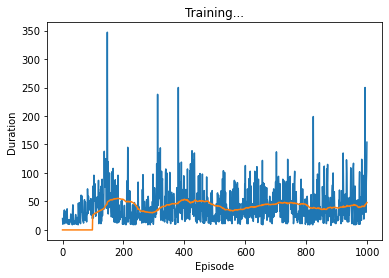

In [64]:
num_episodes = 1000
try:
    for i_episode in range(num_episodes):
        # 환경과 상태 초기화
        env.reset()
        last_screen = get_screen()
        current_screen = get_screen()
        state = current_screen - last_screen
        
        for t in count():
            # 행동 선택과 수행
            action = select_action(state)
            _, reward, done, _ = env.step(action.item())
            reward = torch.tensor([reward], device=device)

            # 새로운 상태 관찰
            last_screen = current_screen
            current_screen = get_screen()
            if not done:
                next_state = current_screen - last_screen
            else:
                next_state = None

            # 메모리에 변이 저장
            memory.push(state, action, next_state, reward)

            # 다음 상태로 이동
            state = next_state
            
            env.render()

            # policy network 업데이트
            optimize_model()
            if done:
                episode_durations.append(t + 1)
                plot_durations()
                break
        # target network 업데이트, 모든 weight 복사
        if i_episode % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())
except KeyboardInterrupt:
    print("\nTraining interrupted")
finally:
    env.render()
    env.close()
    plt.ioff()
    plt.show()
    plot_loss()
    plot_epsiolon()

### Problem

위 결과 score는 사실 그다지 높지 않다. 그 이유는 이미지 기반 학습을 사용했기 때문이다. Reinforcement Learning (RL)에서 이미지 기반 학습은 굉장히 어려운 주제이다. 일반적인 state 정보와는 다르게 이미지는 굉장히  sensory한 정보여서 학습이 잘 되지 않는다. 아래는 이에 대한 자료이다.

![](https://miro.medium.com/max/1400/0*RGbjPYg8axVQQ7Au)

따라서 이미지 기반 학습 시 이미지에 대한 또다른 전처리가 필요하다. 대표적으로 sensory한 image space를 feature space로 인코딩하는 방식을 생각해볼 수 있다.